In [1]:
import duckdb

import pandas as pd
import geopandas as gpd
import shapely

from functools import partial
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [19]:
connection = duckdb.connect(
    database='./databases/berlinmod.db',
    config={'allow_unsigned_extensions' : 'true'}
)

connection.load_extension('~/duckdb/mobilityduck/build/release/extension/mobilityduck/mobilityduck.duckdb_extension')
connection.load_extension('spatial');

## Create table and load data from CSV

In [20]:
query = """
CREATE OR REPLACE TABLE trips (
    tripid INTEGER,
    vehicleid INTEGER,
    posx DOUBLE,
    posy DOUBLE,
    t TIMESTAMPTZ
);
"""
connection.execute(query)

In [21]:

query = "COPY trips FROM 'data/trips_100k.csv';"
connection.execute(query)


In [22]:
query = "SELECT COUNT(*) FROM trips;"
result = connection.execute(query).fetchone()
result


(100000,)

In [23]:
query = "SELECT * FROM trips LIMIT 5;"
result = connection.execute(query).df()
result

,tripid,vehicleid,posx,posy,t
0,1,1,105.680333,21.107531,2020-06-01 09:21:03.543000+00:00
1,1,1,105.680294,21.107512,2020-06-01 09:21:05.043000+00:00
2,1,1,105.680254,21.107493,2020-06-01 09:21:05.793000+00:00
3,1,1,105.680014,21.107377,2020-06-01 09:21:09.393000+00:00
4,1,1,105.680014,21.107377,2020-06-01 09:21:10.169623+00:00


In [24]:
query = """
CREATE OR REPLACE TABLE trajectories(
    tripid integer PRIMARY KEY,
    vehicleid integer NOT NULL,
    trip tgeompoint NOT NULL
);

CREATE OR REPLACE TABLE traj_temp (
    tripid integer NOT NULL,
    vehicleid integer NOT NULL,
    tgeom tgeompoint[] NOT NULL
);

INSERT INTO traj_temp(tripid, vehicleid, tgeom)
SELECT tripid, vehicleid,
    array_agg(
        tgeompoint(
        ST_Transform(
            ST_Point(PosX, PosY),
            'EPSG:4326',
            'EPSG:3857',
            always_xy := true
        )::WKB_BLOB, t
        )
        ORDER BY t
    )
FROM trips
GROUP BY vehicleid, tripid
ORDER BY vehicleid, tripid;

INSERT INTO trajectories(tripid, vehicleid, trip)
SELECT tripid, vehicleid, tgeompointSeq(tgeom) FROM traj_temp;
"""

connection.execute(query)

In [27]:
query = "SELECT asText(trip) FROM trajectories LIMIT 5;"
connection.execute(query).df().head()

,astext(trip)
0,[POINT(11764280.900951382 2404705.174917868)@2...
1,[POINT(11761565.885362627 2389119.1866996125)@...
2,[POINT(11764280.900951382 2404705.174917868)@2...
3,[POINT(11762296.419520957 2406852.2928497843)@...
4,[POINT(11746067.985854387 2405922.9453527434)@...


## Load municipalities of Hanoi into DuckDB

In [28]:
query = """
CREATE OR REPLACE TABLE hanoi(
    municipalityid BIGINT PRIMARY KEY,
    municipalityname VARCHAR,
    population BIGINT,
    percpop DOUBLE,
    popdensitykm2 BIGINT,
    noenterp BIGINT,
    percenterp DOUBLE,
    municipalitygeo VARCHAR,
    geom GEOMETRY
);

COPY hanoi(municipalityid, municipalityname, population,
    percpop, popdensitykm2, noenterp, percenterp, municipalitygeo)
FROM 'data/municipalities.csv' (DELIMITER ',', HEADER);

UPDATE hanoi
SET geom = ST_GeomFromHEXWKB(municipalitygeo);
"""

connection.execute(query)

In [29]:
query = "SELECT * FROM hanoi;"

hanoi = connection.execute(query).df()
hanoi.head(2)

,municipalityid,municipalityname,population,percpop,popdensitykm2,noenterp,percenterp,municipalitygeo,geom
0,1,Quận Ba Đình,223100,0.03,24224,3981,0.03,0103000020110F0000010000009601000055AD2419DB76...,"[2, 4, 0, 0, 0, 0, 0, 0, 216, 182, 51, 75, 213..."
1,2,Quận Bắc Từ Liêm,359200,0.04,7938,6409,0.05,0103000020110F0000010000003A01000049B8A0504872...,"[2, 4, 0, 0, 0, 0, 0, 0, 66, 146, 51, 75, 221,..."


In [31]:
hanoi['geom_obj'] = hanoi['municipalitygeo'].apply(lambda x: shapely.wkb.loads(x))
hanoi_gdf = gpd.GeoDataFrame(hanoi, geometry='geom_obj')
hanoi_gdf['color'] = random.sample(list(mcolors.CSS4_COLORS.values()), hanoi_gdf.shape[0])
hanoi_gdf.head(2)

,municipalityid,municipalityname,population,percpop,popdensitykm2,noenterp,percenterp,municipalitygeo,geom,geom_obj,color
0,1,Quận Ba Đình,223100,0.03,24224,3981,0.03,0103000020110F0000010000009601000055AD2419DB76...,"[2, 4, 0, 0, 0, 0, 0, 0, 216, 182, 51, 75, 213...","POLYGON ((11777752.786 2395483.963, 11777961.3...",#9400D3
1,2,Quận Bắc Từ Liêm,359200,0.04,7938,6409,0.05,0103000020110F0000010000003A01000049B8A0504872...,"[2, 4, 0, 0, 0, 0, 0, 0, 66, 146, 51, 75, 221,...","POLYGON ((11768386.52 2400374.69, 11768448.424...",#E0FFFF


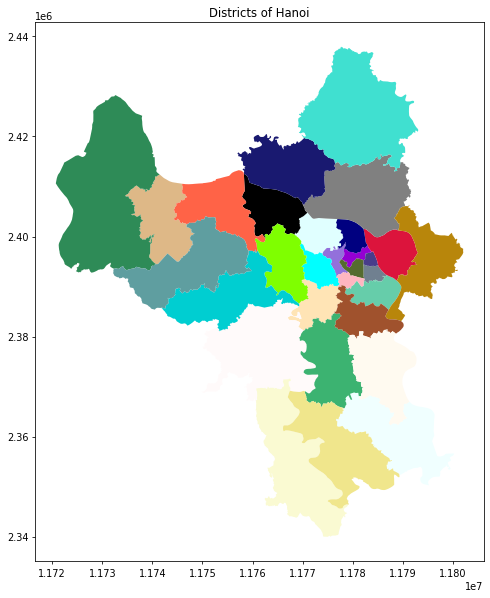

In [52]:
_, axes = plt.subplots(figsize=(10, 10), dpi=70)
hanoi_gdf.plot(color=hanoi_gdf["color"], ax=axes)
# hanoi_gdf.exterior.plot(ax=axes)

axes.set_title("Districts of Hanoi")

plt.show()

## Sort trips by number of districts intersected

In [41]:
query = """
SELECT vehicleid, tripid,
    COUNT(DISTINCT h.municipalityid) AS intersect_count,
    ST_AsText(trajectory(traj.trip)::GEOMETRY) AS trajectory
FROM trajectories traj, hanoi h
WHERE ST_Intersects(trajectory(traj.trip)::GEOMETRY, h.geom)
GROUP BY vehicleid, tripid, ST_AsText(trajectory(traj.trip)::GEOMETRY)
ORDER BY intersect_count DESC;
"""

intersect_count_df = connection.execute(query).df()
intersect_count_df['geom_obj'] = intersect_count_df['trajectory'].apply(lambda x: shapely.wkt.loads(x))
intersect_count_gdf = gpd.GeoDataFrame(intersect_count_df, geometry='geom_obj')
intersect_count_gdf

,vehicleid,tripid,intersect_count,trajectory,geom_obj
0,5,38,9,LINESTRING (11782018.09220447 2393554.89742376...,"LINESTRING (11782018.092 2393554.897, 11782016..."
1,5,37,9,LINESTRING (11756592.709375337 2403942.1525703...,"LINESTRING (11756592.709 2403942.153, 11756587..."
2,3,29,5,LINESTRING (11769125.959336719 2354572.6806168...,"LINESTRING (11769125.959 2354572.681, 11769130..."
3,3,24,5,LINESTRING (11782755.761942161 2389117.3745429...,"LINESTRING (11782755.762 2389117.375, 11782754..."
4,3,27,5,LINESTRING (11769125.959336719 2354572.6806168...,"LINESTRING (11769125.959 2354572.681, 11769130..."
5,3,28,5,LINESTRING (11782755.761942161 2389117.3745429...,"LINESTRING (11782755.762 2389117.375, 11782754..."
6,3,23,5,LINESTRING (11769125.959336719 2354572.6806168...,"LINESTRING (11769125.959 2354572.681, 11769130..."
7,3,30,5,LINESTRING (11782755.761942161 2389117.3745429...,"LINESTRING (11782755.762 2389117.375, 11782754..."
8,2,11,4,LINESTRING (11772905.166993558 2383043.5715297...,"LINESTRING (11772905.167 2383043.572, 11772905..."
9,2,17,4,LINESTRING (11772905.166993558 2383043.5715297...,"LINESTRING (11772905.167 2383043.572, 11772905..."


/home/ubuntu/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


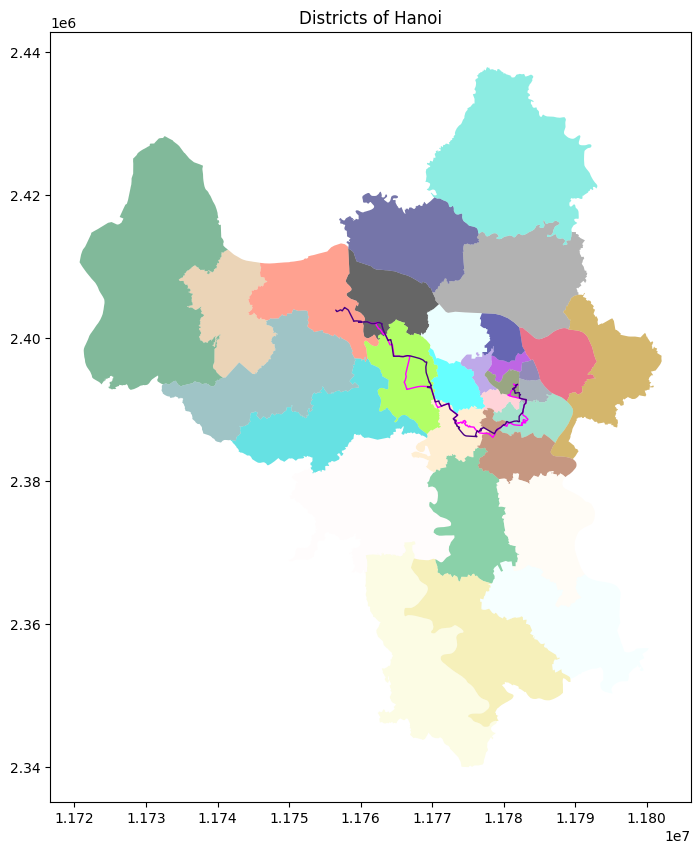

In [60]:
_, axes = plt.subplots(figsize=(10, 10), dpi=100)
hanoi_gdf.plot(color=hanoi_gdf["color"], ax=axes, alpha=0.6)
# hanoi_gdf.exterior.plot(ax=axes)

axes.set_title("Districts of Hanoi")

trips_plot = intersect_count_gdf[intersect_count_gdf['intersect_count'] == intersect_count_gdf['intersect_count'].max()]
trips_plot['color'] = random.sample(list(mcolors.CSS4_COLORS.values()), trips_plot.shape[0])
trips_plot.plot(ax=axes, color=trips_plot['color'], linewidth=1)

plt.show()

In [61]:
connection.close()